In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import pymorphy2
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df_geo = pd.read_excel('geo_comment.xlsx', usecols=range(1,6))
df_geo.comment_class = df_geo.comment_class.replace(-1, 0)
# Количество строк больше 60 000 может привести к зависанию компьютера во время обучения
# моделей из-за окончания оперативной памяти
df_geo = df_geo[:60000]
df_geo[:5]

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,0,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,0,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,0,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,0,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,0,1,Учитывая социальную значимость проекта строите...


Посмотрим каких классов комментариев больше

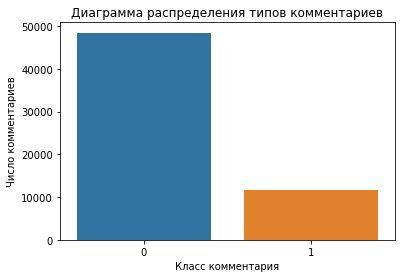

In [3]:
sns.countplot(x='comment_class', data=df_geo)
plt.title('Диаграмма распределения типов комментариев')
plt.xlabel('Класс комментария')
plt.ylabel('Число комментариев')
plt.show()

Как видно из графика, голосующих против примерно в пять раз больше. Построим точечную диаграмму с координатами проголосовавших людей и подкрасим цветом распределение голосов ЗА и ПРОТИВ

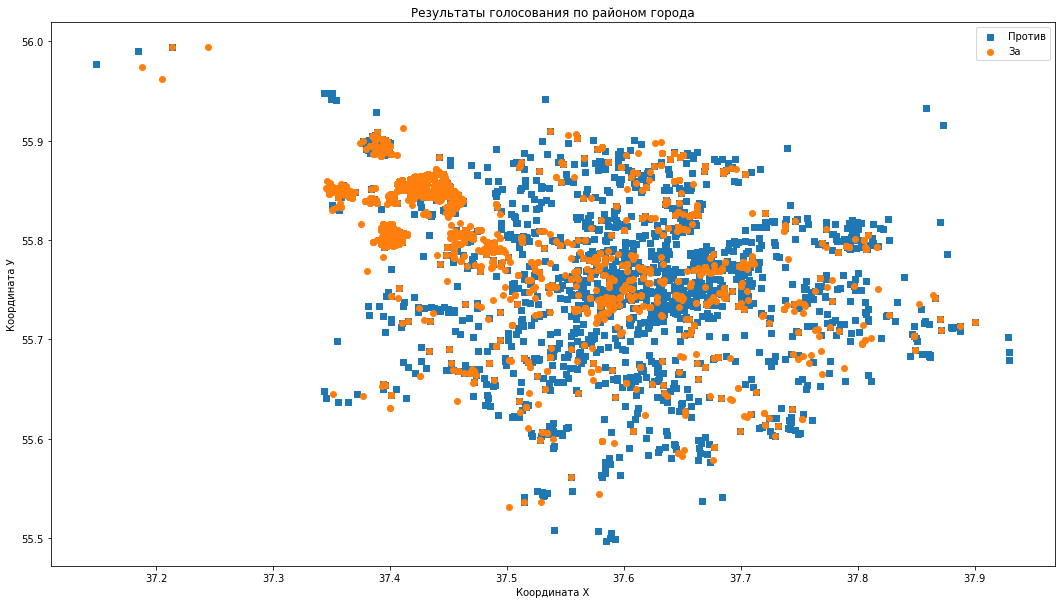

In [4]:
plt.figure(figsize=[18,10])
plt.scatter(df_geo[df_geo.comment_class == 0].x, 
            df_geo[df_geo.comment_class == 0].y, marker='s', label='Против')
plt.scatter(df_geo.x[df_geo.comment_class == 1], 
            df_geo[df_geo.comment_class == 1].y, marker='o', label='За')
plt.title('Результаты голосования по районом города')
plt.xlabel('Координата Х')
plt.ylabel('Координата У')
plt.legend()
plt.show()

Как видно из графика в целом люди голосуют против, но есть отдельные районы с большинством голосов ЗА.

Проверим оптимальное количество кластеров для K-Means методом локтя.

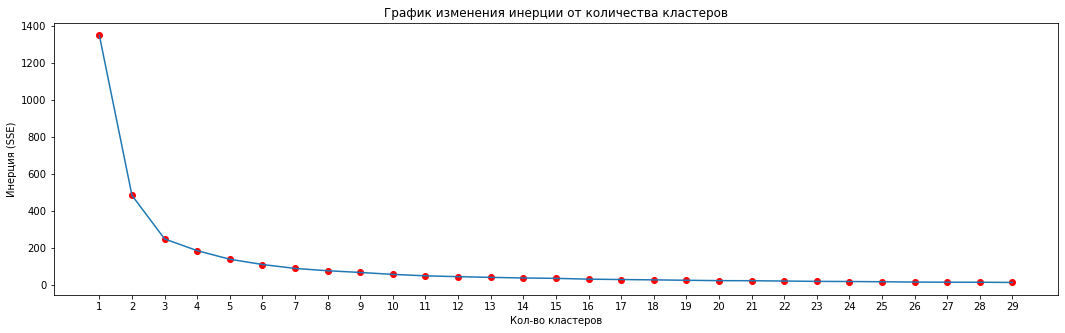

In [5]:
inertia = []
clusters_range = range(1, 30)
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_geo[['x', 'y']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=[18,5])
plt.plot(clusters_range, inertia)
plt.scatter(clusters_range, inertia, c='red')
plt.xticks(clusters_range)
plt.title('График изменения инерции от количества кластеров')
plt.ylabel('Инерция (SSE)')
plt.xlabel('Кол-во кластеров')
plt.show()

Как видно из графика оптимальное значение кластеров - 3 или 4. После увеличения количества кластеров больше 4 ошибка SSE меняется уже незначительно, кластеры становится все больше друг на друга похожи.

Для нашей задачи больше подхоит алгоритм DBSCAN, который позволяет сделать кластеризацию по определенной плотности точек.

Но тем не менее попробуем разбить даныне на 4 кластера с помощью K-Means

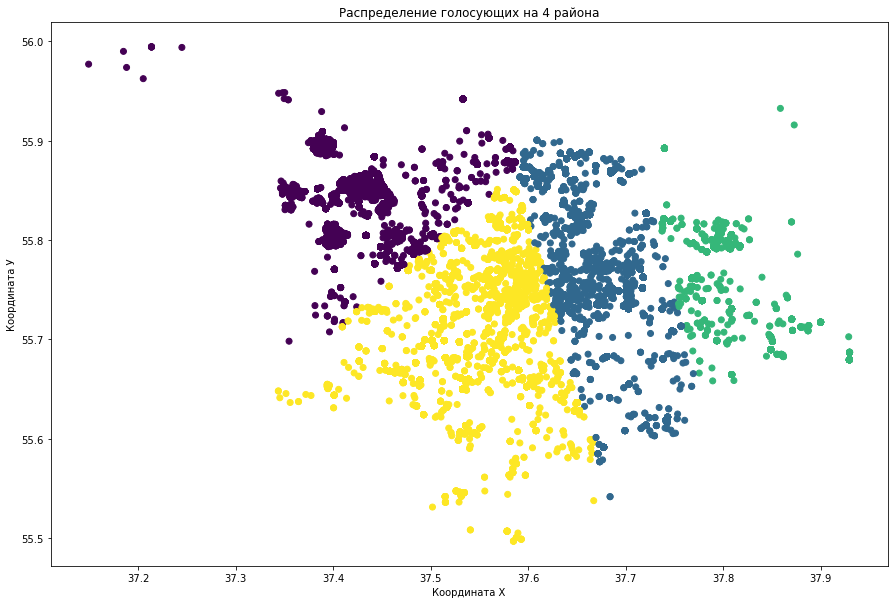

In [6]:
kmeans = KMeans(n_clusters=4)
kmeans_predict = kmeans.fit_predict(df_geo[['x', 'y']])
plt.figure(figsize=[15,10])
plt.scatter(df_geo.x, df_geo.y, c=kmeans_predict)
plt.title('Распределение голосующих на 4 района')
plt.xlabel('Координата Х')
plt.ylabel('Координата У')
plt.show()

Не смотря на то, что метод локтя показал 4 оптимальных кластера, такие разбиение не похоже на реальное. Разница в расстояниях между людьми примерно 20-40 киллометров. Более логично разбивать людей на группы в радиусе 3-4 километров, что может соответствовать определенному району города.

Попробуем разбить данные на 10 районов.

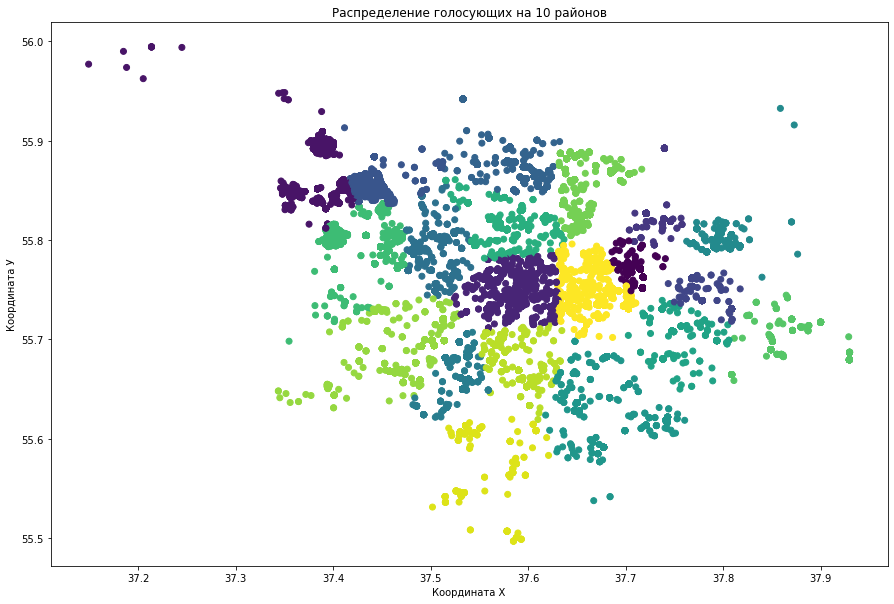

In [7]:
kmeans = KMeans(n_clusters=20)
kmeans_predict = kmeans.fit_predict(df_geo[['x', 'y']])
plt.figure(figsize=[15,10])
plt.scatter(df_geo.x, df_geo.y, c=kmeans_predict)
plt.title('Распределение голосующих на 10 районов')
plt.xlabel('Координата Х')
plt.ylabel('Координата У')
plt.show()

Теперь разбиение стало более логичным.

Попробуем кластеризовать даныне с помощью DBSCAN. Будем использовать оценку haversine для расчета расстояния между двумя точками на сфере.

Количество районов: 47

Кол-во выбросов: 1870 из 60000

Топ-10 районов с максимальным кол-вом голосовавших жителей:
Кластер 1: 12461
Кластер 12: 7337
Кластер 19: 6658
Кластер 0: 6250
Кластер 7: 3537
Кластер 23: 3531
Кластер 20: 2605
Кластер 2: 1912
Кластер 25: 1613
Кластер 14: 1410

Кол-во кластеров с менее чем 100 жителями: 11


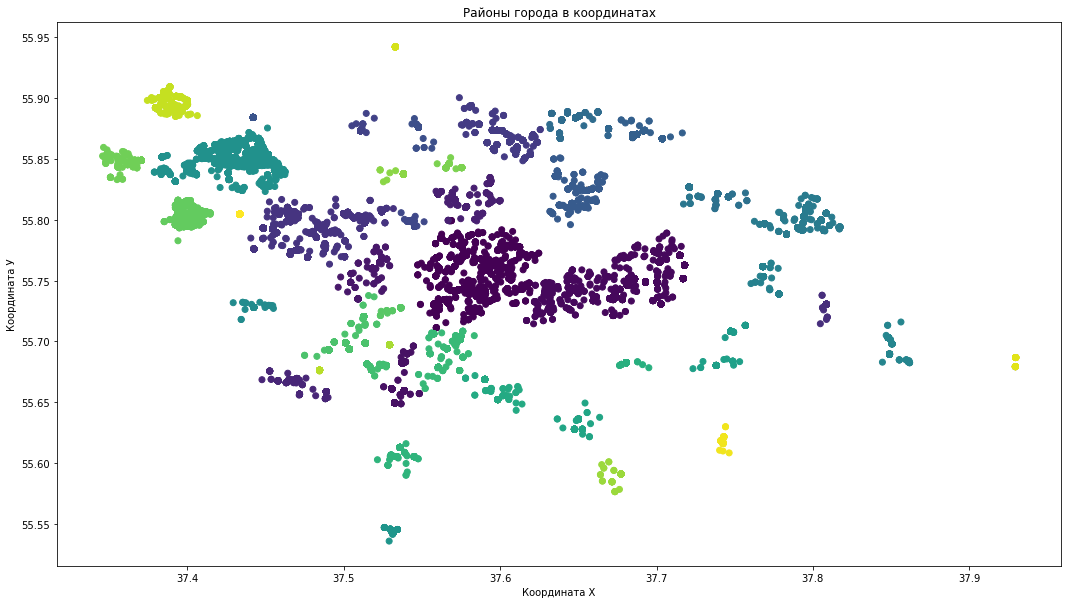

In [8]:
coords = np.matrix(df_geo[['x', 'y']])

# Рассчитываем epsilon как расстояние между людьми в 1 км.                
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian

# Берем метрику haversine, которая используется для расчета
# расстояний геокоординат. В радиусе 1 киллометра должно быть 50 человек
dbscan = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', 
                metric='haversine')
# Метрика haversine требует координаты в радианах
dbscan_predict = dbscan.fit_predict(np.radians(coords))

# Находим количество людей в каждом кластере без выбросов
predict_bin_count = np.bincount(dbscan_predict[dbscan_predict != -1])
# Количество найденных кластеров
clusters_count = len(predict_bin_count)

# Отсортированный список кортежей в формате 
# (номер кластера, количество жителей)
clusters_size_sorted = sorted(zip(range(clusters_count), predict_bin_count), 
                              key=lambda x: x[1], reverse=True)

# Текстовый список с 10 самыми большими кластерами для выврда на экран
cluster_top_10 = [f'Кластер {r_num}: {cluster_count}' 
                  for r_num, cluster_count in clusters_size_sorted][:10]

# Кол-во выбросов
outliers = len(dbscan_predict[dbscan_predict == -1])

print(f'Количество районов: {clusters_count}')
print(f'\nКол-во выбросов: {outliers} из {len(df_geo)}')
print('\nТоп-10 районов с максимальным кол-вом голосовавших жителей:\n', 
      "\n".join(cluster_top_10), sep='')

filter_cluster_size = 100
print(f'\nКол-во кластеров с менее чем {filter_cluster_size} жителями:', len([cluster_size 
                                                                              for cluster_size in predict_bin_count 
                                                                              if cluster_size < filter_cluster_size]))
plt.figure(figsize=[18,10])
plt.scatter(df_geo[dbscan_predict != -1].x, df_geo[dbscan_predict != -1].y, 
            c=dbscan_predict[dbscan_predict != -1])
plt.title('Районы города в координатах')
plt.xlabel('Координата Х')
plt.ylabel('Координата У')
plt.show()

В итоге мы получили 47 кластера, при этом 1 870 из 60 000 человек мы не смогли кластеризовать в виду различной плотности разных участков данных. Если искать по 1 человеку на определенном расстоянии, то у нас получится слоишком много кластеров (несколько сотен) с количеством жителей менее 10 человек на кластер. Подобрать значения не приводящие к выбросам очень тяжело.

Теперь покажем на графиках 4 самых больших кластера. 

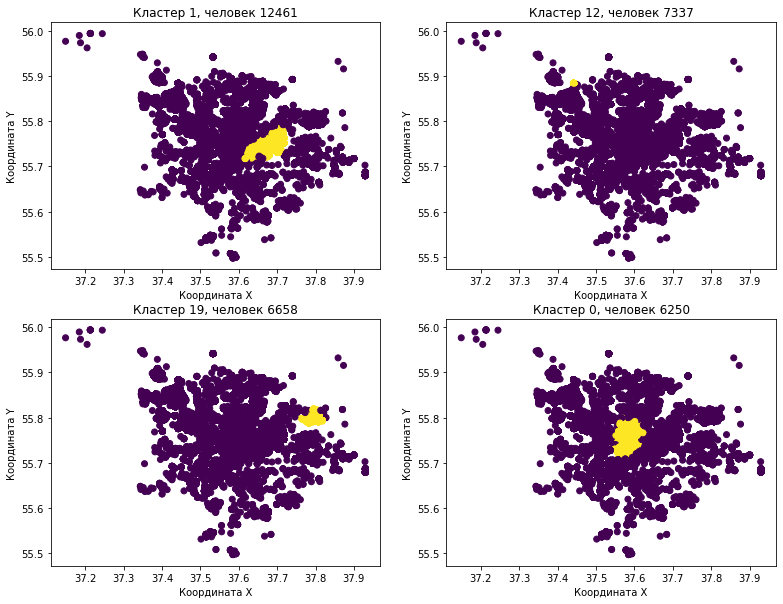

In [9]:
f, axarr = plt.subplots(2,2, figsize=(13,10))
for cluster, ax_plot in zip(clusters_size_sorted, axarr.flatten()):
    ax_plot.scatter(df_geo.x, df_geo.y, c=np.where(dbscan_predict == cluster[0], 1, 0))
    ax_plot.set_title(f'Кластер {cluster[0]}, человек {cluster[1]}')
    ax_plot.set_xlabel('Координата Х')
    ax_plot.set_ylabel('Координата Y')

Теперь попробуем определить тематику сообщений жителей с помощью латентного размещения Дирихле.

In [10]:
class TextPreprocessing:
    """ Предобработка текста
    """
    
    def __init__(self):
        
        self._morph = pymorphy2.MorphAnalyzer()
        self._snowball = SnowballStemmer(language="russian")
        
    def start(self, text, stopwords=None, mode=None):
        """ Делает стемминг или лемматизацию текста на русском языке
        Входные параметры
        -----------------
        text : str
          Текст на русском языке
        stopwords : list
          Список стоп-слов
        mode : str
          Режим работы. Принимает значение stem или lemm.
          None - не применяется стеминг/лемматизация
          lemm - к словам применяется лемматизация
          stem - к словам применяется стеминг

        Результат
        ---------
        text : str
          Текст с отфильтрованными словами с примененным стеммингом или леммтизацией
        """

        if mode:
            mode = mode.lower().strip()

        if mode not in ('stem', 'lemm', None):
            raise ValueError('Параметр mode должен принимать значение stem, lemm или None')

        if not stopwords:
            stopwords = []

        text = text.lower()
        text = re.sub(r'[^А-Яа-яёЁ ]', '', text)
        word_tokens = word_tokenize(text, language='russian')
        
        # список результирующих слов для текста
        word_result = []

        for word in word_tokens:

            if word in stopwords:
                continue

            if mode == 'lemm':
                lem_result = self._morph.parse(word)
                if len(lem_result) > 0:
                    word_result.append(lem_result[0].normal_form)            
            elif mode == 'stem':
                word_result.append(self._snowball.stem(word)) 
            else:
                word_result.append(word)

        return ' '.join(word_result)

In [11]:
#text_prep = TextPreprocessing()
#russian_stopwords = stopwords.words('russian')
#df_geo.comment = df_geo.comment.apply(text_prep.start, stopwords=russian_stopwords, mode='lemm')

# Операция лемматизации идет 100 минут, поэтому загрузим уже предсохраненный лематизированный файл
df_geo_lemm = pd.read_excel('geo_comment_lemmatize.xlsx')
df_geo_lemm[:5]

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,0,1,раздел правило землепользование застройка гмос...
1,37.612416,55.777454,0,1,основание вступить законный сила судебный реше...
2,37.603298,55.742108,0,1,внести проект правило землепользование застрой...
3,37.558526,55.728758,0,1,учитывать социальный значимость проект строите...
4,37.566431,55.731794,0,1,учитывать социальный значимость проект строите...


Попробуем обучить модель для 5000 тысяч слов. С помощью max_df = 0.1 говорим модели учитывать только те термы, которые встречаются не в более чем в 10% документов.

In [12]:
count = CountVectorizer(max_df=.1, max_features=5000)
X = count.fit_transform(df_geo_lemm.comment.values)

Попробуем выделить 5 тем из наших данных.

In [13]:
lda = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch')
X_topics = lda.fit_transform(X)

Выведем 15 самых популярных слов для каждой из пяти тем и попробуем по словам сформулировать тематики.

In [14]:
n_top_words = 15
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print(f'Тема {topic_idx+1}')
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]) + '\n')

Тема 1
максимально кладбище основной метро станция отправить соответственно противоречащий уплотнительный условноразрешить здоровье расстояние полоса фактический сп

Тема 2
северозападный третий кольцо корпус уля отправить предложениятребовать неиспользуемый доработковать гостиница нужный уходить поддержать улучшить разместиться

Тема 3
классификатор статья местный кадастр самоуправление населить нужда раздел случай область вопрос подлежать программа произвольно индекс

Тема 4
вернуть группа парковочный противоречие снести направление течение исключить ой стр тысквмга строить самостоятельно посредством разъяснение

Тема 5
квм стр парк квмга тыс лосиный школа привести национальный проектный постройка переулок жильё немой разрабатывать



Без понимания предметной области тяжело сформулировать темы по самым популярным словам. 
Выведем 5 сообщений по тематике №5

In [15]:
topic_number = 5
message_numbers = 5
for topic_idx, i in enumerate(X_topics[:, topic_number-1].argsort()[::-1][:message_numbers], 1):
    print(f'Тема {topic_number}, метка {df_geo.iloc[i].comment_class}. Cообщение {topic_idx}:\n')
    print(df_geo.iloc[i].comment[:500] + '...\n')

Тема 5, метка 0. Cообщение 1:

Мы, жители города Москвы, поддерживаем принятие правил землепользования и застройки (ПЗЗ), которые позволят регулировать градостроительную деятельность в интересах горожан, а также учесть потребности жителей в комплексном благоустройстве территории и объектах торгово-бытовой и социальной инфраструктуры.В рамках рассматриваемого проекта ПЗЗ для участков заброшенной промышленной (не функционирующей) зоны с кадастровыми номерами 77:08:0005010:1002, 77:08:0005010:18 (адрес: г. Москва, Волоколамское ...

Тема 5, метка 0. Cообщение 2:

Мы, жители города Москвы, поддерживаем принятие правил землепользования и застройки (ПЗЗ), которые позволят регулировать градостроительную деятельность в интересах горожан, а также учесть потребности жителей в комплексном благоустройстве территории и объектах торгово-бытовой и социальной инфраструктуры.В рамках рассматриваемого проекта ПЗЗ для участков заброшенной промышленной (не функционирующей) зоны с кадастровыми номерами 77: